In [20]:
# 1️⃣ Imports
!pip3 install wandb tensorflow scikit-learn seaborn matplotlib nbformat
import os
import wandb
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
# 2️⃣ Login to WandB
wandb.login()

True

In [22]:
# 3️⃣ Download the UCI Dermatology dataset
import urllib.request
data_path = "dermatology.data"
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/dermatology/dermatology.data"

if not os.path.exists(data_path):
    print("Downloading dermatology.data ...")
    urllib.request.urlretrieve(data_url, data_path)
    print("Download complete.")
else:
    print("dermatology.data already exists")

dermatology.data already exists


In [23]:
# 4️⃣ Load and preprocess dataset
data = np.loadtxt(
    './dermatology.data', 
    delimiter=',', 
    converters={33: lambda x:int(x == '?'), 34: lambda x:int(x) - 1}
)
sz = data.shape

# Train/test split 70/30
train = data[:int(sz[0]*0.7), :]
test = data[int(sz[0]*0.7):, :]

train_X = train[:, :33]
train_Y = train[:, 34]

test_X = test[:, :33]
test_Y = test[:, 34]

# Scale features for neural network
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [24]:
# 5️⃣ Initialize WandB run
run = wandb.init(project="Lab1-visualize-models", name="keras_nn")

In [25]:
# 6️⃣ Build a small neural network
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(33,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(6, activation='softmax')  # 6 classes
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

/Users/akashdhadiwal/Downloads/IE7374/IE7374-MLOps/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
# 7️⃣ Train the model with WandB callback
history = model.fit(
    train_X, train_Y,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    callbacks=[wandb.keras.WandbCallback(
        log_model=False,
        save_model=False,
        save_graph=False
    )]
)


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3469 - loss: 1.7442 - val_accuracy: 0.6923 - val_loss: 1.1590
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7027 - loss: 1.1247 - val_accuracy: 0.8077 - val_loss: 0.7083
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7869 - loss: 0.7421 - val_accuracy: 0.9038 - val_loss: 0.4599
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9106 - loss: 0.4404 - val_accuracy: 0.9038 - val_loss: 0.3221
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9366 - loss: 0.3496 - val_accuracy: 0.9231 - val_loss: 0.2181
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.2019 - val_accuracy: 0.9615 - val_loss: 0.1499
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9888 - loss: 0.1675 - val_accuracy: 0.9808 - val_loss: 0.1030
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9907 - loss: 0.1034 - val_accuracy: 0.9808 - val_loss:

In [27]:
# 8️⃣ Evaluate on test set
test_loss, test_acc = model.evaluate(test_X, test_Y)
print(f"Test Accuracy: {test_acc:.4f}")
run.summary['Test Accuracy'] = test_acc

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8772 - loss: 0.4291
Test Accuracy: 0.8909


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


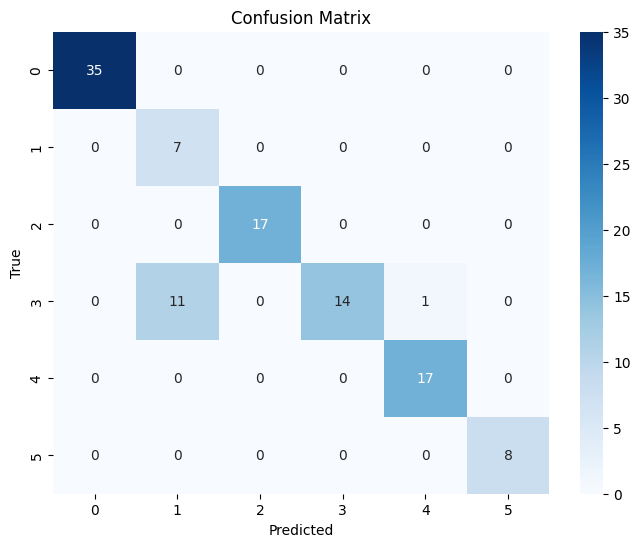

<Figure size 640x480 with 0 Axes>

In [28]:
# 9️⃣ Confusion matrix
pred = np.argmax(model.predict(test_X), axis=1)
cm = confusion_matrix(test_Y, pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Log confusion matrix to WandB
wandb.log({"confusion_matrix": wandb.Image(plt)})

In [29]:
# 🔚 Finish WandB run
run.finish()

accuracy,▁▅▆▇▇███████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▆▇█████████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
val_loss,█▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test Accuracy,0.89091
accuracy,1
best_epoch,14
best_val_loss,0.04914
epoch,49
loss,0.00234
